In [117]:
import json
with open('people_detections_with_rgb_color.json', 'r') as f:
    data = json.load(f)

print(data)

[{'frame_id': 0, 'detections': [{'bbox': [144, 256, 172, 317], 'confidence': 0.7891722321510315, 'track_id': 1, 'class': 'person', 'dominant_color_rgb': [147, 129, 96]}, {'bbox': [8, 269, 45, 334], 'confidence': 0.7556441426277161, 'track_id': 2, 'class': 'person', 'dominant_color_rgb': [152, 132, 93]}, {'bbox': [628, 228, 648, 280], 'confidence': 0.6303842067718506, 'track_id': 3, 'class': 'person', 'dominant_color_rgb': [125, 106, 64]}, {'bbox': [701, 303, 734, 368], 'confidence': 0.5941866040229797, 'track_id': 4, 'class': 'person', 'dominant_color_rgb': [149, 161, 52]}, {'bbox': [445, 211, 464, 265], 'confidence': 0.570283830165863, 'track_id': 5, 'class': 'person', 'dominant_color_rgb': [112, 145, 91]}, {'bbox': [328, 286, 353, 344], 'confidence': 0.3892908990383148, 'track_id': 6, 'class': 'person', 'dominant_color_rgb': [184, 200, 85]}, {'bbox': [629, 228, 656, 280], 'confidence': 0.36975961923599243, 'track_id': 7, 'class': 'person', 'dominant_color_rgb': [125, 106, 64]}, {'bbo

In [118]:
all_track_ids = []
for frame in data:
    detections = frame['detections']
    for detection in detections:
        all_track_ids.append(detection['track_id'])

print(len(all_track_ids))
print(len(set(all_track_ids)))

all_unique_track_ids = list(set(all_track_ids))

1211
45


In [119]:
def get_overlapping_bboxes(frame):
    detections = frame['detections']
    overlapping_pairs = []
    
    for i, detection1 in enumerate(detections):
        bbox1 = detection1['bbox']
        x1_min, y1_min, x1_max, y1_max = bbox1
        
        for j, detection2 in enumerate(detections[i+1:], i+1):
            bbox2 = detection2['bbox']
            x2_min, y2_min, x2_max, y2_max = bbox2
            
            # Check if bboxes overlap
            if not (x1_max < x2_min or x2_max < x1_min or 
                   y1_max < y2_min or y2_max < y1_min):
                overlapping_pairs.append((detection1['track_id'], detection2['track_id']))
                
    return overlapping_pairs

def get_bbox_size(bbox):
    x1, y1, x2, y2 = bbox
    return (x2 - x1) * (y2 - y1)

In [120]:
import colorsys
import numpy as np


def classify_color_hsv_distance(rgb_color):
    # Convert input to HSV
    h, s, v = rgb_to_hsv(rgb_color)
    hsv_input = np.array([h, s, v])

    # Define weights for HSV components
    weights = np.array([2.0, 0, 0])  # Higher weight for hue, lower for value

    # Display RGB color as a small rectangle
    fig_debug = plt.figure(figsize=(2, 2))
    ax_debug = fig_debug.add_subplot(111)
    rgb_normalized = [x/255.0 for x in rgb_color]
    rect = patches.Rectangle((0, 0), 1, 1, facecolor=rgb_normalized)
    ax_debug.add_patch(rect)
    ax_debug.set_xlim(0, 1)
    ax_debug.set_ylim(0, 1)
    ax_debug.axis('off')
    print(f"RGB: {tuple(rgb_color)}")
    print(f"HSV: {tuple(hsv_input)}")
    plt.show()

    # Compute weighted Euclidean distance in HSV space
    distances = {
        name: np.linalg.norm(weights * (hsv_input - np.array(hsv)))
        for name, hsv in color_refs.items()
    }

    closest_color = min(distances.items(), key=lambda x: x[1])[0]
    print(f"Closest color: {closest_color}")

    # Return the closest color
    return closest_color


In [121]:
track_id_to_colors = {}

yellow_rgb = (255, 255, 0)
red_rgb = (0, 0, 255)
blue_rgb = (0, 255, 255)

for track_id in all_unique_track_ids:
    if track_id not in track_id_to_colors:
        track_id_to_colors[track_id] = []

    for frame in data:
        overlapping_pairs = get_overlapping_bboxes(frame)

        overlapping_track_ids = []
        for i, j in overlapping_pairs:
            overlapping_track_ids.append(i)
            overlapping_track_ids.append(j)
        overlapping_track_ids = list(set(overlapping_track_ids))
        
        detections = frame['detections']
        for detection in detections:
            if detection['track_id'] == track_id:
                # Find closest color between red, yellow and blue
                rgb_color = detection['dominant_color_rgb']

                track_id_to_colors[track_id].append(
                    {
                        "frame_id": frame['frame_id'],
                        "dominant_color_rgb": detection['dominant_color_rgb'], 
                        "bbox_size": get_bbox_size(detection['bbox']),
                        "has_overlap": track_id in overlapping_track_ids
                    }
                )


In [122]:
for track_id, colors in track_id_to_colors.items():
    if len(colors) == 0:
        continue
    
    bbox_sizes = [color['bbox_size'] for color in colors]
    max_bbox_size = max(bbox_sizes)

    for color in colors:
        color["confidence"] = 1 - (color["bbox_size"] / max_bbox_size)
        if color["has_overlap"]:
            color["confidence"] = 0

In [123]:
all_player_colors = []
for track_id, colors in track_id_to_colors.items():
    if len(colors) == 0:
        continue
        
    # Filter out colors with overlap
    non_overlapping_colors = [color for color in colors if not color['has_overlap']]
    
    if len(non_overlapping_colors) == 0:
        continue

    all_player_colors.extend(non_overlapping_colors)

print(len(all_player_colors))

1032


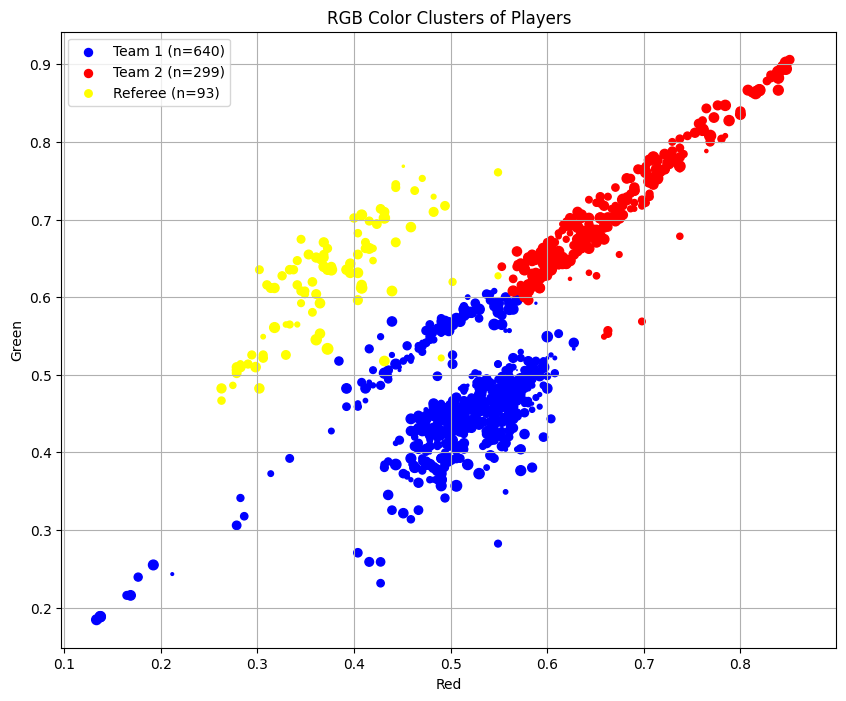


Cluster Centers:
Team 1 RGB: [0.5116973  0.45661765 0.31047181]
Team 1 HSV: (0.12104648802273653, 0.3932510268354309, 0.5116973039215686)
Team 2 RGB: [0.66387304 0.70792839 0.34261919]
Team 2 HSV: (0.1867662370301224, 0.5160256410256411, 0.7079283887468031)
Referee RGB: [0.37495256 0.61724647 0.55424837]
Referee HSV: (0.4566655064392621, 0.39253996447602146, 0.6172464684798651)


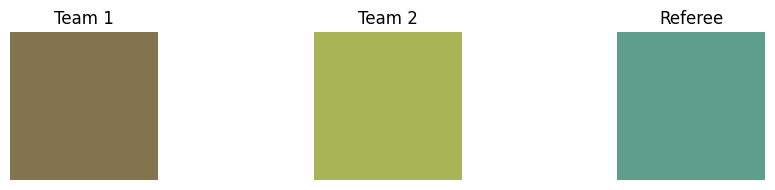

In [129]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from colorsys import rgb_to_hsv

# Extract RGB colors and confidences
rgb_colors = np.array([color['dominant_color_rgb'] for color in all_player_colors])
confidences = np.array([color['confidence'] for color in all_player_colors])

# Normalize RGB values to 0-1 range if needed
rgb_colors = rgb_colors / 255.0 if np.any(rgb_colors > 1.0) else rgb_colors

# Perform k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(rgb_colors)

# Get cluster sizes and sort indices by size (descending)
cluster_sizes = np.bincount(cluster_labels)
cluster_size_order = np.argsort(-cluster_sizes)

# Map clusters to teams/referee based on size
cluster_mapping = {
    cluster_size_order[0]: 'Team 1',
    cluster_size_order[1]: 'Team 2', 
    cluster_size_order[2]: 'Referee'
}

# Create scatter plot
plt.figure(figsize=(10, 8))

# Plot each cluster with different colors and labels
colors = ['blue', 'red', 'yellow']
for i, cluster_idx in enumerate(cluster_size_order):
    mask = cluster_labels == cluster_idx
    plt.scatter(
        rgb_colors[mask, 0], 
        rgb_colors[mask, 1],
        c=colors[i],  # Use predefined colors instead of RGB values
        marker='o',
        s=100 * confidences[mask],
        label=f'{cluster_mapping[cluster_idx]} (n={cluster_sizes[cluster_idx]})'
    )

plt.xlabel('Red')
plt.ylabel('Green')
plt.title('RGB Color Clusters of Players')
plt.legend()
plt.grid(True)
plt.show()

# Print cluster centers
print("\nCluster Centers:")
for i, cluster_idx in enumerate(cluster_size_order):
    rgb_color = kmeans.cluster_centers_[cluster_idx]
    print(f"{cluster_mapping[cluster_idx]} RGB: {rgb_color}")
    print(f"{cluster_mapping[cluster_idx]} HSV: {rgb_to_hsv(rgb_color[0], rgb_color[1], rgb_color[2])}")


# Create a figure to display average colors
plt.figure(figsize=(10, 2))

# Plot each cluster center as a solid color patch
for i, cluster_idx in enumerate(cluster_size_order):
    center = kmeans.cluster_centers_[cluster_idx]
    plt.subplot(1, 3, i+1)
    plt.axis('off')
    plt.title(cluster_mapping[cluster_idx])
    # Create a solid color patch using the cluster center RGB values
    plt.imshow([[center]])

plt.tight_layout()
plt.show()


In [130]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from colorsys import rgb_to_hsv

# Define colors in HSV
color_refs = {
    "team1": kmeans.cluster_centers_[cluster_size_order[0]],  # Largest cluster
    "team2": kmeans.cluster_centers_[cluster_size_order[1]],  # Second largest
    "referee": kmeans.cluster_centers_[cluster_size_order[2]] # Third largest
}

In [134]:
track_id_to_color = {}
for track_id, colors in track_id_to_colors.items():
    if len(colors) == 0:
        continue
        
    # Filter out colors with overlap
    non_overlapping_colors = [color for color in colors if not color['has_overlap']]
    
    if len(non_overlapping_colors) == 0:
        continue
        
    # Calculate average RGB color from non-overlapping detections only
    rgb_values = np.array([color['dominant_color_rgb'] for color in non_overlapping_colors])

    team_assignments = []
    for rgb_color in rgb_values:
        # Normalize RGB values to [0,1] range
        rgb_color = [x/255.0 for x in rgb_color]
        
        # Find closest cluster center
        distances = np.linalg.norm(kmeans.cluster_centers_ - rgb_color, axis=1)
        closest_cluster = cluster_mapping[np.argmin(distances)]
        team_assignments.append(closest_cluster)

    # Use majority voting to determine the final team assignment
    from collections import Counter
    most_common_team = Counter(team_assignments).most_common(1)[0][0]
    track_id_to_color[track_id] = most_common_team

In [135]:
track_id_to_color = dict(sorted(track_id_to_color.items(), key=lambda x: x[0]))
for track_id, color in track_id_to_color.items():
    print(f"Track ID: {track_id}, Team: {color}")

Track ID: 1, Team: Team 1
Track ID: 2, Team: Team 2
Track ID: 3, Team: Team 1
Track ID: 4, Team: Team 2
Track ID: 5, Team: Referee
Track ID: 6, Team: Team 1
Track ID: 8, Team: Team 1
Track ID: 9, Team: Team 1
Track ID: 11, Team: Team 1
Track ID: 12, Team: Team 1
Track ID: 23, Team: Team 2
Track ID: 26, Team: Team 1
Track ID: 47, Team: Team 2
Track ID: 61, Team: Team 1
Track ID: 69, Team: Team 1
Track ID: 75, Team: Team 1
Track ID: 84, Team: Team 1
Track ID: 93, Team: Team 1
Track ID: 104, Team: Team 2
Track ID: 121, Team: Referee
Track ID: 122, Team: Team 1
Track ID: 123, Team: Team 2
Track ID: 126, Team: Team 1
Track ID: 127, Team: Team 1
Track ID: 134, Team: Team 1
Track ID: 144, Team: Team 1
Track ID: 156, Team: Team 2
Track ID: 181, Team: Team 1
Track ID: 185, Team: Team 1
Track ID: 197, Team: Team 2
Track ID: 203, Team: Team 2
Track ID: 212, Team: Team 1
Track ID: 213, Team: Team 1
Track ID: 238, Team: Team 1
Track ID: 242, Team: Team 1
Track ID: 259, Team: Team 1
Track ID: 264, T